In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("dataset_clean.csv",sep=";")

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_3304\1189747591.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("dataset_clean.csv",sep=";")


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_24692\4089122170.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gravite_blessure', data=dataset, palette='viridis')


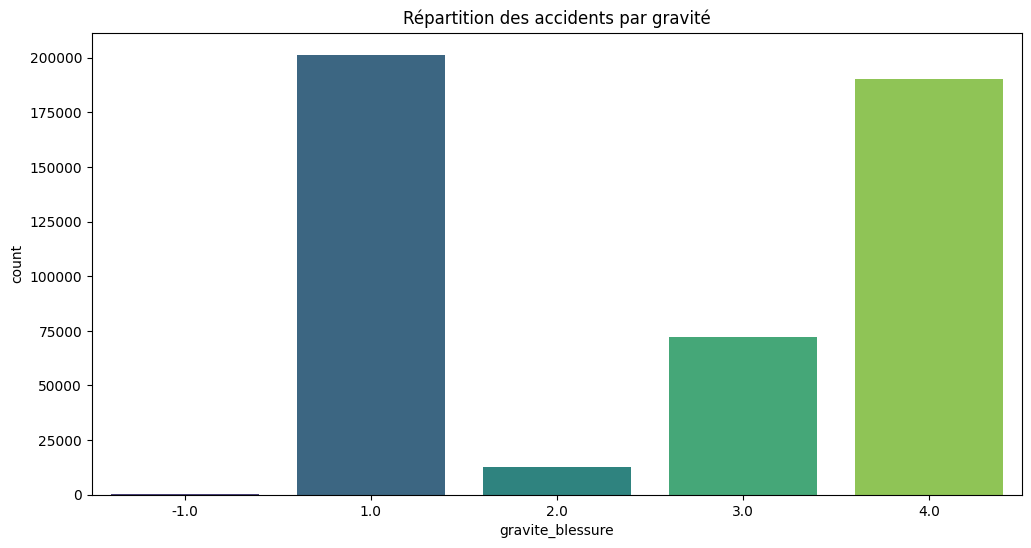

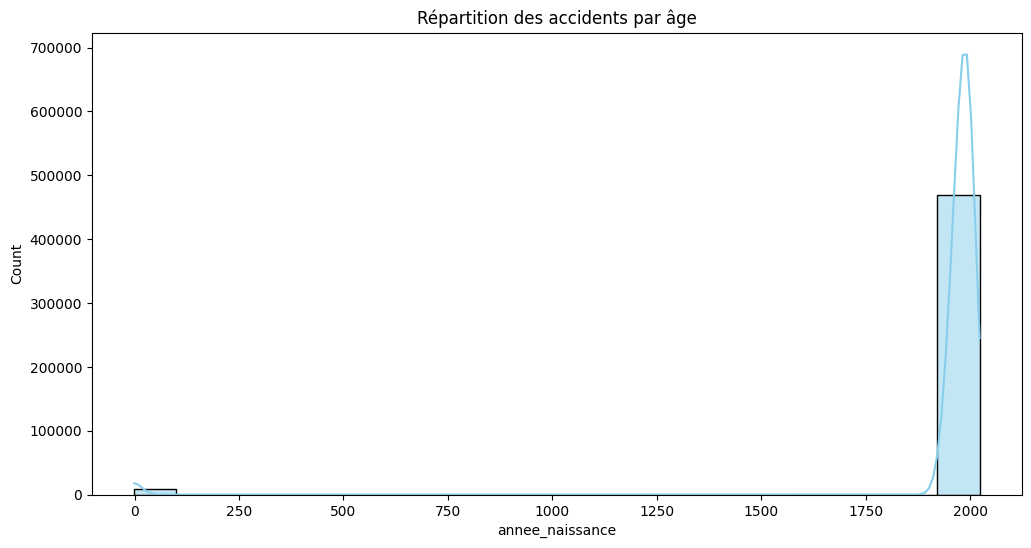

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_24692\4089122170.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='categorie_vehicule', data=dataset, palette='coolwarm')


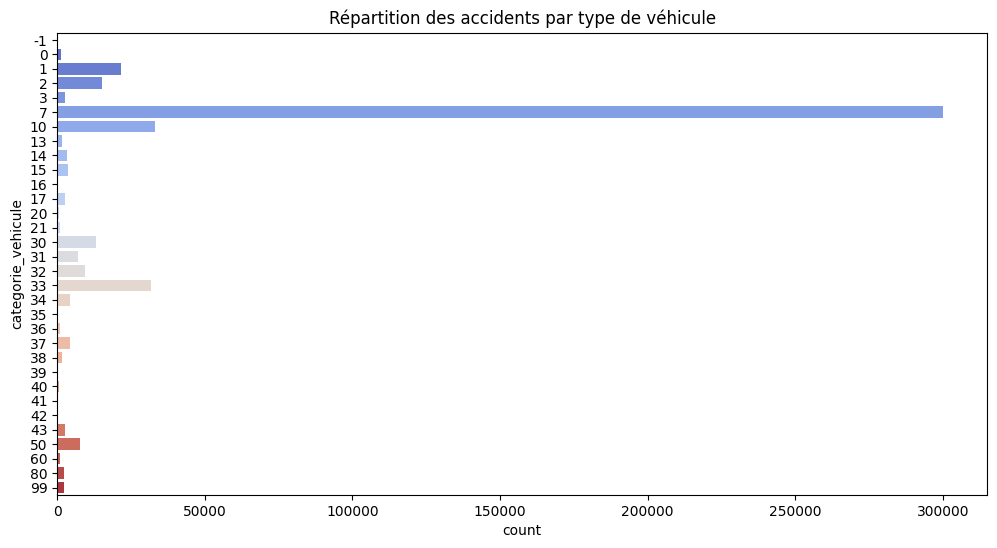

In [85]:
# Répartition par gravité
plt.figure(figsize=(12, 6)) 
sns.countplot(x='gravite_blessure', data=dataset, palette='viridis') 
plt.title("Répartition des accidents par gravité") 
plt.show() 

# Répartition par tranche d'âge
plt.figure(figsize=(12, 6)) 
sns.histplot(dataset['annee_naissance'], bins=20, kde=True, color='skyblue') 
plt.title("Répartition des accidents par âge") 
plt.show() 

# Répartition par type de véhicule
plt.figure(figsize=(12, 6)) 
sns.countplot(y='categorie_vehicule', data=dataset, palette='coolwarm') 
plt.title("Répartition des accidents par type de véhicule") 
plt.show()

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_24692\1543882450.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gravite_blessure', data=dataset[dataset['gravite_blessure']==2], palette='viridis')


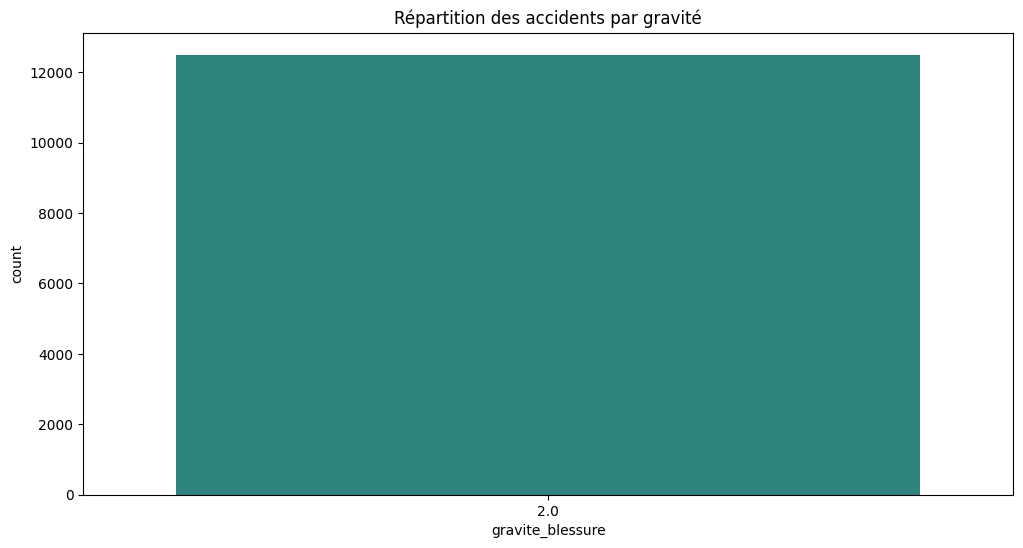

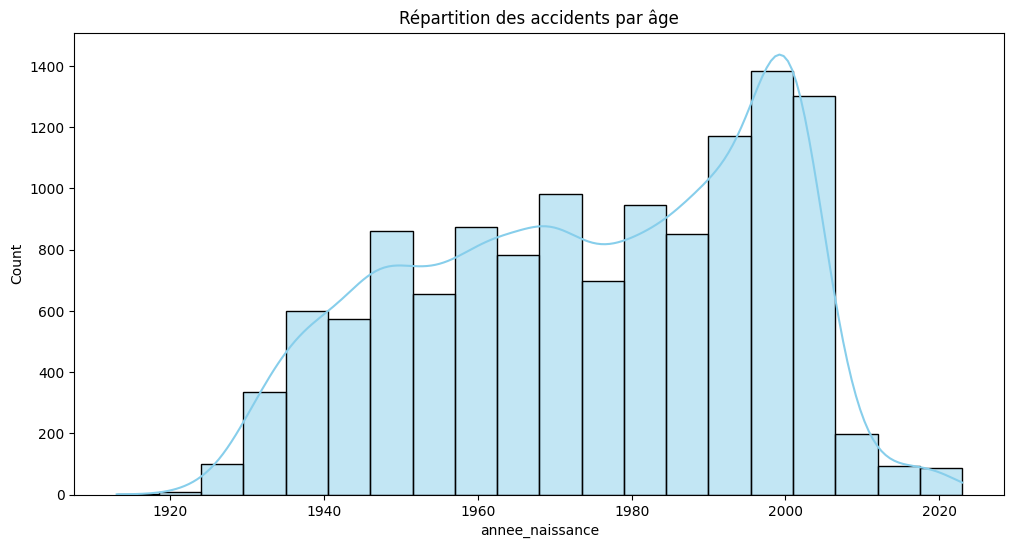

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_24692\1543882450.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='categorie_vehicule', data=dataset[dataset['gravite_blessure']==2], palette='coolwarm')


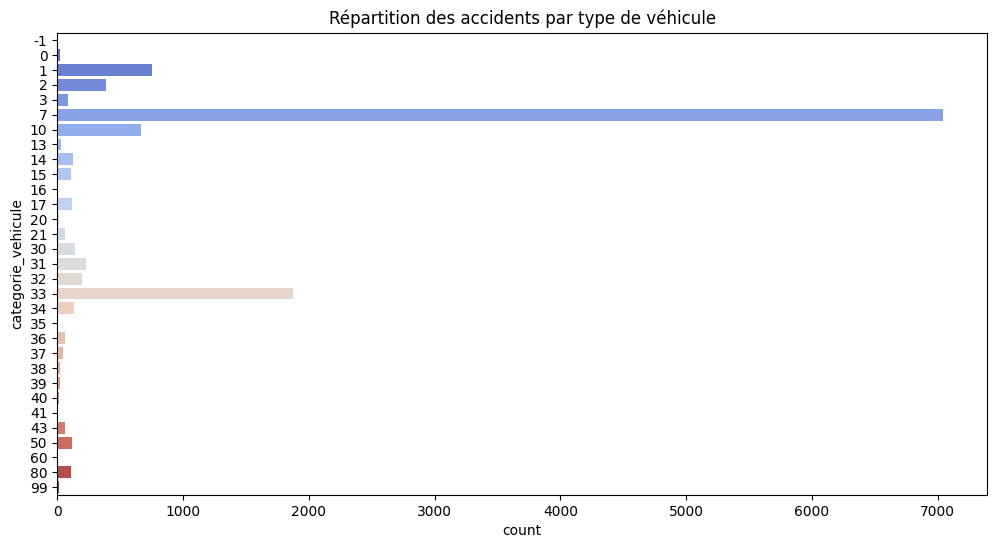

In [87]:
# Répartition par tranche d'âge
plt.figure(figsize=(12, 6)) 
sns.histplot(dataset[dataset['gravite_blessure']==2]['annee_naissance'], bins=20, kde=True, color='skyblue') 
plt.title("Répartition des accidents par âge") 
plt.show() 

# Répartition par type de véhicule
plt.figure(figsize=(12, 6)) 
sns.countplot(y='categorie_vehicule', data=dataset[dataset['gravite_blessure']==2], palette='coolwarm') 
plt.title("Répartition des accidents par type de véhicule") 
plt.show()

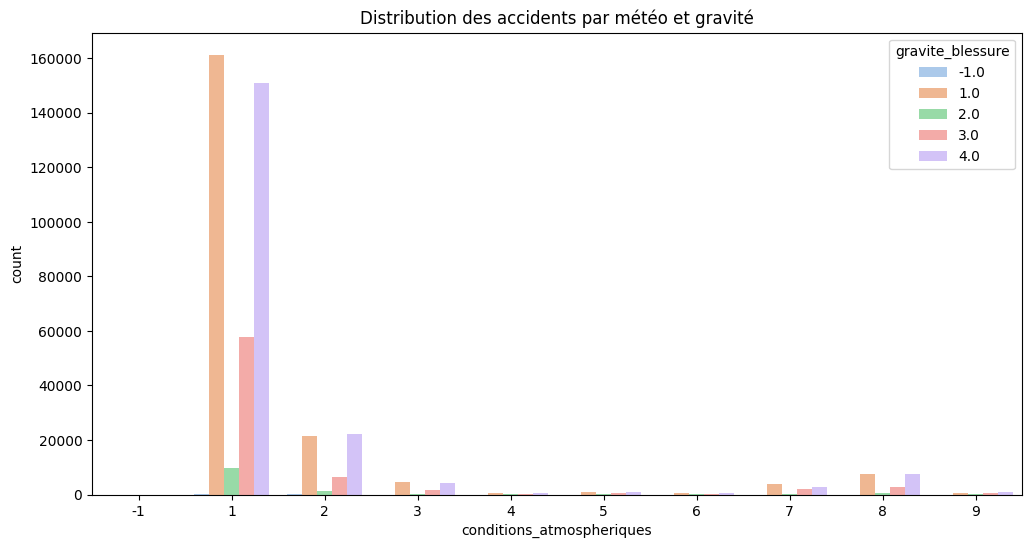

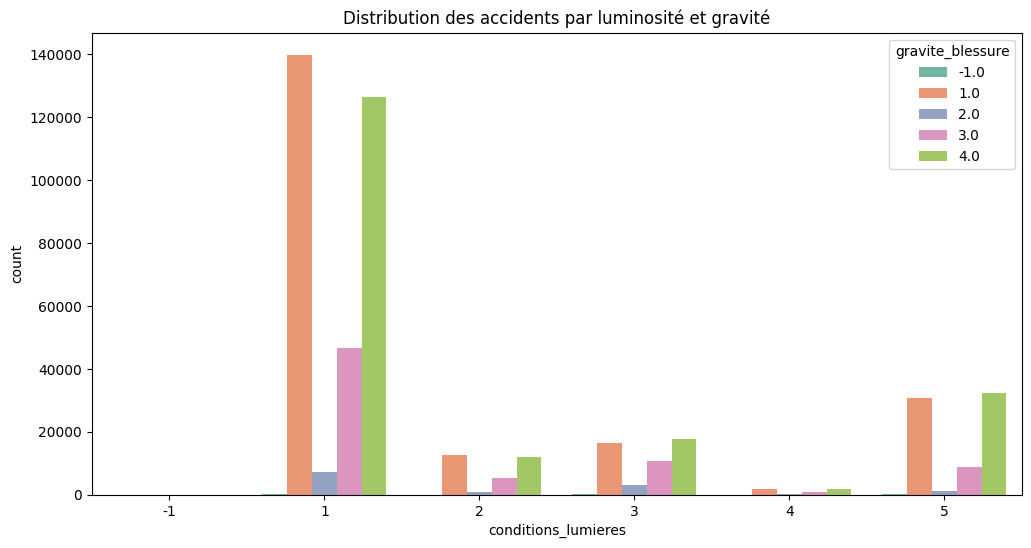

In [88]:
# Analyse par météo
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_atmospheriques', hue='gravite_blessure', data=dataset, palette='pastel')
plt.title("Distribution des accidents par météo et gravité")
plt.show()

# Analyse par luminosité
plt.figure(figsize=(12, 6))
sns.countplot(x='conditions_lumieres', hue='gravite_blessure', data=dataset, palette='Set2')
plt.title("Distribution des accidents par luminosité et gravité")
plt.show() 

# **Data Analysis**

In [20]:
# pour sépare les variables 
 
def split_columns(df):
    numerical_columns = df.select_dtypes(include=['number']).columns
    non_numerical_columns = df.select_dtypes(exclude=['number']).columns
    return numerical_columns, non_numerical_columns
 
 
numerical_columns, non_numerical_columns = split_columns(dataset)
 
print("Numerical columns:\n", numerical_columns)
print("\nNon-numerical columns:\n", non_numerical_columns)

Numerical columns:
 Index(['numero_accident', 'jour_accident', 'mois_accident', 'annee_accident',
       'conditions_lumieres', 'localisation', 'type_intersection',
       'conditions_atmospheriques', 'type_collision', 'categorie_route',
       'regime_circulation', 'nombre_voies', 'presence_voie_reservee',
       'profil_route', 'tracage_route', 'etat_surface', 'infrastructure',
       'situation_accident', 'vitesse_max_autorisee', 'sens_circulation',
       'categorie_vehicule', 'obstacle_fixe_heurte', 'obstacle_mobile_heurte',
       'point_choc_initial', 'manoeuvre_avant_accident', 'type_motorisation',
       'place_occupant', 'categorie_usager', 'gravite_blessure', 'sexe_usager',
       'annee_naissance', 'motif_deplacement', 'equipement_securite_1',
       'equipement_securite_2', 'equipement_securite_3', 'localisation_pieton',
       'etat_pieton', 'identifiant_usager'],
      dtype='object')

Non-numerical columns:
 Index(['heure_accident', 'departement', 'commune', 'numero_pr'

In [30]:
# Analyse des variables numériques  
numerical_analysis = dataset[numerical_columns].describe()  
print("Statistiques descriptives des variables numériques :")
print(numerical_analysis)

# Calcul de la corrélation entre les variables numériques
correlation_matrix = dataset[numerical_columns].corr()

# Affichage de la matrice de corrélation sous forme de tableau
print("\nMatrice de corrélation des variables numériques :")
print(correlation_matrix)

# Calcul de la corrélation de la 'gravite_blessure' avec les autres variables numériques
if 'gravite_blessure' in dataset.columns:
    gravity_correlation = correlation_matrix['gravite_blessure'].drop('gravite_blessure')
    print("\nCorrélation de 'gravite_blessure' avec les autres variables numériques :")
    print(gravity_correlation)

    # Trier les corrélations de manière décroissante par valeur absolue 
    top_corr = gravity_correlation.abs().sort_values(ascending=False).head()
    print("\nTop  des variables les plus corrélées avec 'gravite_blessure' :")
    
    # Créer une table de top  corrélations
    top_table = pd.DataFrame({
        'Variable': top_corr.index,
        'Corrélation avec gravite_blessure': top_corr.values
    })

    # Affichage de la table des top  variables les plus corrélées
    print(top_table)



Statistiques descriptives des variables numériques :
       numero_accident  jour_accident  mois_accident  annee_accident  \
count     4.768270e+05  476827.000000  476827.000000   476827.000000   
mean      2.021553e+11      15.595730       6.745153     2021.552546   
std       1.091067e+08       8.747984       3.356652        1.091057   
min       2.020000e+11       1.000000       1.000000     2020.000000   
25%       2.021000e+11       8.000000       4.000000     2021.000000   
50%       2.022000e+11      15.000000       7.000000     2022.000000   
75%       2.023000e+11      23.000000      10.000000     2023.000000   
max       2.023001e+11      31.000000      12.000000     2023.000000   

       conditions_lumieres   localisation  type_intersection  \
count        476827.000000  476827.000000      476827.000000   
mean              1.906457       1.617794           2.059504   
std               1.476673       0.485927           1.993129   
min              -1.000000       1.000000 